### Created by: Anthony D. Cho
### Last update: 13.11.2021

**Subject**: Regression (LSTM - keras, tensorflow) - Metro Interstate Traffic Volume

## Libraries dependencies

In [1]:
from time import time
from pandas import set_option, read_csv
set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import zeros, round, argmin, append

## Pre-processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Imbalance-data functions
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

## tensorflow-Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## Customized functions

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

    @param width: width of the graphic display
    @type width: int

    @param height: height of the graphic display
    @type height: int

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

# Problem: Metro Interstate Traffic Volume

**Target**: traffic_volume

## Data loading
Source: [Metro Interstate Traffic Volume](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#) (UCI Repository)

In [3]:
## Download and uncompress .gz file
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!gzip -d Metro_Interstate_Traffic_Volume.csv.gz

--2021-12-03 19:33:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolviendo archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Conectando con archive.ics.uci.edu (archive.ics.uci.edu)[128.195.10.252]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 405373 (396K) [application/x-httpd-php]
Guardando como: “Metro_Interstate_Traffic_Volume.csv.gz”

Metro_Interstate_Tr 100%[===================>] 395,87K   562KB/s    en 0,7s    

2021-12-03 19:34:01 (562 KB/s) - “Metro_Interstate_Traffic_Volume.csv.gz” guardado [405373/405373]



In [4]:
## Loading data
data = read_csv('Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'])
N = len(data)

## display number of samples
print('Number of samples:', N)

## display datetime interval of the data
print('From: {} To: {}\n'.format(data['date_time'].iloc[0], 
                               data['date_time'].iloc[-1]))

## Display first five records of the data
data.head()

Number of samples: 48204
From: 2012-10-02 09:00:00 To: 2018-09-30 23:00:00



,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### Pre-processing

In [5]:
start = time()

## Features selection
data.drop(columns=['holiday', 'weather_main', 'weather_description', 'date_time'], inplace=True)

## Number of lookback samples to consider in timesteps
lookback = 23

## Number of samples for every partition: train, validation, and test
n_train, n_val = round(0.7*N).astype(int), round(0.1*N).astype(int)
n_test = N -n_train -n_val -lookback
print(f'Number of samples for: train {n_train}, validation {n_val}, test {n_test-1}')

## Creating partition sets
print('Creating partition...')
train_data = data.iloc[ :(n_train +lookback +1) ]
val_data = data.iloc[n_train:(n_train +n_val +lookback +1)]
test_data = data.iloc[(n_train +n_val):]

## Data scaling (Highlight: this will convert dataframe -> numpy.ndarray)
print('Scaling data...')
scale = StandardScaler().fit(train_data)
train_data = scale.transform(train_data)
val_data = scale.transform(val_data)
test_data = scale.transform(test_data)

## Split data: predictors and target
print('Splitting data...')
X_train, y_train = train_data[:-1, :-1], train_data[(lookback +1):, -1]
X_val, y_val = val_data[:-1, :-1], val_data[(lookback +1):, -1]
X_test, y_test = test_data[:-1, :-1], test_data[(lookback +1):, -1]

## Convert to RNN accepatble format (sample, timesteps, features)
print('Converting to RNN tensor format...')
X_train2 = zeros((n_train, lookback+1, X_train.shape[1]))
X_val2 = zeros((n_val, lookback+1, X_val.shape[1]))
X_test2 = zeros((n_test-1, lookback+1, X_test.shape[1]))

h = lookback +1
for i in range(n_train):
    X_train2[i] = X_train[i:(i +h)]
y_train = y_train.reshape(-1, 1)

for i in range(n_val):
    X_val2[i] = X_val[i:(i +h)]
y_val = y_val.reshape(-1, 1)

for i in range(n_test-1):
    X_test2[i] = X_test[i:(i +h)]
y_test = y_test.reshape(-1, 1)

## Display data shape
print('(train shape) X: {}, y: {}'.format(X_train2.shape, y_train.shape))
print('(val shape) X: {}, y: {}'.format(X_val2.shape, y_val.shape))
print('(test shape) X: {}, y: {}'.format(X_test2.shape, y_test.shape))

print('Time spent[s]: {:.2f}'.format(time()-start))

Number of samples for: train 33743, validation 4820, test 9617
Creating partition...
Scaling data...
Splitting data...
Converting to RNN tensor format...
(train shape) X: (33743, 24, 4), y: (33743, 1)
(val shape) X: (4820, 24, 4), y: (4820, 1)
(test shape) X: (9617, 24, 4), y: (9617, 1)
Time spent[s]: 0.25


## Model building

In [6]:
## Model instance
model = Sequential(name='Traffic_volume')
model.add(layers.LSTM(units=50, input_shape=X_train2.shape[1:],
                      kernel_regularizer=l2(0.0001),
                      return_sequences = True,
                      name='LSTM_01'))
model.add(layers.LSTM(units=75,
                      kernel_regularizer=l2(0.0001), name='LSTM_02'))
model.add(layers.Dense(units=1,
                       name='Output'))

## Compiler settings
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mae', 
              metrics=['mse'])

## Display model
model.summary()

Model: "Traffic_volume"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_01 (LSTM)               (None, 24, 50)            11000     
_________________________________________________________________
LSTM_02 (LSTM)               (None, 75)                37800     
_________________________________________________________________
Output (Dense)               (None, 1)                 76        
Total params: 48,876
Trainable params: 48,876
Non-trainable params: 0
_________________________________________________________________


In [7]:
## Fit model
start = time()
history = model.fit(x=X_train2, y=y_train, 
                    validation_data=(X_val2, y_val),
                    epochs=30, 
                    batch_size=30,
                    shuffle=False)
print('\nTime spent[s]: ', time()-start)

Epoch 1/30
1125/1125 [==============================] - 69s 58ms/step - loss: 0.8829 - mse: 1.0006 - val_loss: 0.7127 - val_mse: 0.7223
Epoch 2/30
1125/1125 [==============================] - 58s 51ms/step - loss: 0.8099 - mse: 0.9001 - val_loss: 0.6508 - val_mse: 0.6694
Epoch 3/30
1125/1125 [==============================] - 58s 51ms/step - loss: 0.7849 - mse: 0.8668 - val_loss: 0.6298 - val_mse: 0.6418
Epoch 4/30
1125/1125 [==============================] - 58s 51ms/step - loss: 0.7652 - mse: 0.8460 - val_loss: 0.6211 - val_mse: 0.6354
Epoch 5/30
1125/1125 [==============================] - 58s 52ms/step - loss: 0.7470 - mse: 0.8289 - val_loss: 0.6128 - val_mse: 0.6288
Epoch 6/30
1125/1125 [==============================] - 58s 52ms/step - loss: 0.7323 - mse: 0.8128 - val_loss: 0.6103 - val_mse: 0.6335
Epoch 7/30
1125/1125 [==============================] - 59s 53ms/step - loss: 0.7210 - mse: 0.7974 - val_loss: 0.6074 - val_mse: 0.6304
Epoch 8/30
1125/1125 [==========================

## Model performances display

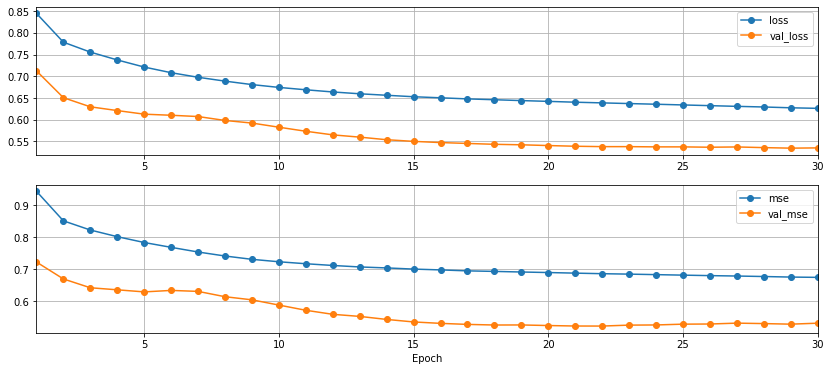

301/301 [==============================] - 7s 22ms/step - loss: 0.5913 - mse: 0.6151


[0.5913341045379639, 0.6150796413421631]

In [8]:
## Display performances
plot_history(history, width=14)

## Compute prediction with test set
model.evaluate(X_test2, y_test)

## Predictions

In [9]:
## Make prediction using test set
prediction = model.predict(X_test2)
prediction

array([[ 0.11770973],
       [ 0.14632522],
       [ 0.20568545],
       ...,
       [-0.26182804],
       [-0.43720543],
       [-0.5957326 ]], dtype=float32)

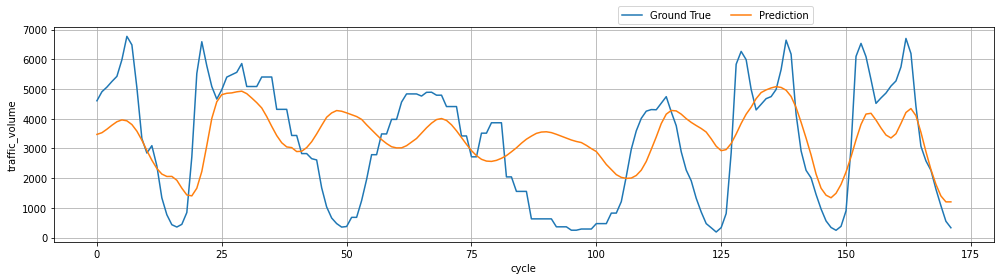

In [10]:
## Number of samples to display
nSamples = 172

## De-codifing results
y_true = y_test.ravel()*scale.scale_[-1] + scale.mean_[-1]
predict_dec = prediction.ravel()*scale.scale_[-1] + scale.mean_[-1]

## Display graphic
plt.figure(figsize=(14, 4))
if nSamples == 'all':
    plt.plot(y_true, label='Ground True')
    plt.plot(predict_dec, label='Prediction')
else:
    plt.plot(y_true[:nSamples], label='Ground True')
    plt.plot(predict_dec[:nSamples], label='Prediction')
plt.legend(loc=[0.6, 1.01], ncol=2)
plt.ylabel('traffic_volume'); plt.xlabel('cycle')
plt.grid()
plt.tight_layout()
plt.show()

### Hold-out Grid Search

**warning**: This process took around 23 hours to finish.

In [11]:
## Model builder

def model_build(lstm1=50, lstm2=100):
    """
        DESCRIPTION:
            Model builder: RNN with 2 LSTM as hidden layers
            
        INPUT:
            @param lstm1: number of units for 1st hidden layer (default 50)
            @type lstm1: int
            
            @param lstm2: number of units for 2nd hidden layer (default 100)
            @type lstm2: int
    """
    
    ## Model instance
    model = Sequential(name='Traffic_volume')
    model.add(layers.LSTM(units=lstm1, input_shape=X_train2.shape[1:],
                        kernel_regularizer=l2(0.0001),
                        return_sequences = True,
                        name='LSTM_01'))
    model.add(layers.LSTM(units=lstm2,
                        kernel_regularizer=l2(0.0001), name='LSTM_02'))
    model.add(layers.Dense(units=1,
                        name='Output'))

    ## Compiler settings
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='mae', 
                metrics=['mse'])

    return model

## Performance-values allocation
performance = {'MAE': {'train': {}, 'val':{}},
               'MSE': {'train': {}, 'val':{}}}

start = time()

## Run Hold-out grid search
for lstm1 in [25, 50, 75, 100]:
    for lstm2 in [50, 75, 100, 125]:
        for epoch in [30, 50]:

          startIter = time()
        
          print('lstm1: {}, lstm2: {}, epochs: {}'.format(lstm1, lstm2, epoch), end=' ')
          name = 'lstm1_{}_lstm2_{}_epoch_{}'.format(lstm1, lstm2, epoch)

          ## model instance
          model = model_build(lstm1, lstm2)
        
          ## model fitting
          history = model.fit(x=X_train2, y=y_train, 
                              validation_data=(X_val2, y_val),
                              epochs=epoch, 
                              batch_size=30, verbose=0,
                              shuffle=False)
          
          ## model performance using train set
          mae, mse = model.evaluate(X_train2, y_train, verbose=0)
          performance['MAE']['train'][name] = mae
          performance['MSE']['train'][name] = mse

          ## model performance using validate set
          mae, mse = model.evaluate(X_val2, y_val, verbose=0)
          performance['MAE']['val'][name] = mae
          performance['MSE']['val'][name] = mse

          print('Time spent[s]: {}'.format(time()-startIter))

print('\nTotal time spent[s]: ', time()-start)

lstm1: 25, lstm2: 50, epochs: 30 Time spent[s]: 1228.9330823421478
lstm1: 25, lstm2: 50, epochs: 50 Time spent[s]: 2071.5583305358887
lstm1: 25, lstm2: 75, epochs: 30 Time spent[s]: 1489.746957540512
lstm1: 25, lstm2: 75, epochs: 50 Time spent[s]: 2415.5646119117737
lstm1: 25, lstm2: 100, epochs: 30 Time spent[s]: 1812.908447265625
lstm1: 25, lstm2: 100, epochs: 50 Time spent[s]: 2959.3870763778687
lstm1: 25, lstm2: 125, epochs: 30 Time spent[s]: 1946.084906578064
lstm1: 25, lstm2: 125, epochs: 50 Time spent[s]: 3249.549674510956
lstm1: 50, lstm2: 50, epochs: 30 Time spent[s]: 1482.200606584549
lstm1: 50, lstm2: 50, epochs: 50 Time spent[s]: 2574.593528985977
lstm1: 50, lstm2: 75, epochs: 30 Time spent[s]: 1696.0233204364777
lstm1: 50, lstm2: 75, epochs: 50 Time spent[s]: 2738.6318271160126
lstm1: 50, lstm2: 100, epochs: 30 Time spent[s]: 2031.631752729416
lstm1: 50, lstm2: 100, epochs: 50 Time spent[s]: 3319.798398256302
lstm1: 50, lstm2: 125, epochs: 30 Time spent[s]: 2150.1826453208

In [12]:
## Summary results

from numpy import argmin

iMin = argmin( list(performance['MAE']['train'].values()) )
setting = list(performance['MAE']['train'].keys())[iMin]
maeTrain = performance['MAE']['train'][setting]
maeVal = performance['MAE']['val'][setting]
mseTrain = performance['MSE']['train'][setting]
mseVal = performance['MSE']['val'][setting]

print('Focus on: {}, configuration: {}'.format('MAE (Train)', setting))
print('MAE (Train): {:.4f}, MAE (Val): {:.4f}, MSE (Train): {:.4f}, MSE (Val): {:.4f}'.format(maeTrain, maeVal,
                                                                                              mseTrain, mseVal))

iMin = argmin( list(performance['MAE']['val'].values()) )
setting = list(performance['MAE']['train'].keys())[iMin]
maeTrain = performance['MAE']['train'][setting]
maeVal = performance['MAE']['val'][setting]
mseTrain = performance['MSE']['train'][setting]
mseVal = performance['MSE']['val'][setting]

print('Focus on: {}, configuration: {}'.format('MAE (Val)', setting))
print('MAE (Train): {:.4f}, MAE (Val): {:.4f}, MSE (Train): {:.4f}, MSE (Val): {:.4f}'.format(maeTrain, maeVal,
                                                                                              mseTrain, mseVal))


iMin = argmin( list(performance['MSE']['train'].values()) )
setting = list(performance['MAE']['train'].keys())[iMin]
maeTrain = performance['MAE']['train'][setting]
maeVal = performance['MAE']['val'][setting]
mseTrain = performance['MSE']['train'][setting]
mseVal = performance['MSE']['val'][setting]

print('Focus on: {}, configuration: {}'.format('MSE (Train)', setting))
print('MAE (Train): {:.4f}, MAE (Val): {:.4f}, MSE (Train): {:.4f}, MSE (Val): {:.4f}'.format(maeTrain, maeVal,
                                                                                              mseTrain, mseVal))

iMin = argmin( list(performance['MSE']['val'].values()) )
setting = list(performance['MAE']['train'].keys())[iMin]
maeTrain = performance['MAE']['train'][setting]
maeVal = performance['MAE']['val'][setting]
mseTrain = performance['MSE']['train'][setting]
mseVal = performance['MSE']['val'][setting]

print('Focus on: {}, configuration: {}'.format('MSE (Val)', setting))
print('MAE (Train): {:.4f}, MAE (Val): {:.4f}, MSE (Train): {:.4f}, MSE (Val): {:.4f}'.format(maeTrain, maeVal,
                                                                                              mseTrain, mseVal))


Focus on: MAE (Train), configuration: lstm1_100_lstm2_125_epoch_50
MAE (Train): 0.6127, MAE (Val): 0.5376, MSE (Train): 0.6805, MSE (Val): 0.5530
Focus on: MAE (Val), configuration: lstm1_75_lstm2_50_epoch_50
MAE (Train): 0.6137, MAE (Val): 0.5253, MSE (Train): 0.6786, MSE (Val): 0.5291
Focus on: MSE (Train), configuration: lstm1_75_lstm2_125_epoch_50
MAE (Train): 0.6141, MAE (Val): 0.5349, MSE (Train): 0.6703, MSE (Val): 0.5352
Focus on: MSE (Val), configuration: lstm1_100_lstm2_50_epoch_30
MAE (Train): 0.6344, MAE (Val): 0.5276, MSE (Train): 0.7076, MSE (Val): 0.5183


### Best model

Minimum MAE(Val): configuration: lstm1: 75, lstm2: 50, epoch: 50

In [13]:
X = append(X_train2, X_val2, axis=0)
y = append(y_train, y_val, axis=0)

## Display data shape
print('(train shape) X: {}, y: {}'.format(X.shape, y.shape))
print('(test shape) X: {}, y: {}'.format(X_test2.shape, y_test.shape))

(train shape) X: (38563, 24, 4), y: (38563, 1)
(test shape) X: (9617, 24, 4), y: (9617, 1)


In [14]:
## model instance
model = model_build(lstm1=75, lstm2=50)

## model display
model.summary()

Model: "Traffic_volume"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_01 (LSTM)               (None, 24, 75)            24000     
_________________________________________________________________
LSTM_02 (LSTM)               (None, 50)                25200     
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 49,251
Trainable params: 49,251
Non-trainable params: 0
_________________________________________________________________


In [15]:
## model fitting
history = model.fit(x=X, y=y, 
                  epochs=50, 
                  batch_size=30,
                  shuffle=False)

Epoch 1/50
1286/1286 [==============================] - 75s 57ms/step - loss: 0.8800 - mse: 0.9947
Epoch 2/50
1286/1286 [==============================] - 69s 54ms/step - loss: 0.7956 - mse: 0.8788
Epoch 3/50
1286/1286 [==============================] - 67s 52ms/step - loss: 0.7724 - mse: 0.8487
Epoch 4/50
1286/1286 [==============================] - 65s 51ms/step - loss: 0.7483 - mse: 0.8233
Epoch 5/50
1286/1286 [==============================] - 67s 52ms/step - loss: 0.7261 - mse: 0.8017
Epoch 6/50
1286/1286 [==============================] - 67s 52ms/step - loss: 0.7107 - mse: 0.7863
Epoch 7/50
1286/1286 [==============================] - 67s 52ms/step - loss: 0.6991 - mse: 0.7739
Epoch 8/50
1286/1286 [==============================] - 68s 53ms/step - loss: 0.6895 - mse: 0.7639
Epoch 9/50
1286/1286 [==============================] - 68s 53ms/step - loss: 0.6819 - mse: 0.7556
Epoch 10/50
1286/1286 [==============================] - 66s 51ms/step - loss: 0.6763 - mse: 0.7493
Epoch 11/

In [16]:
## Compute prediction with test set
model.evaluate(X_test2, y_test)

301/301 [==============================] - 7s 22ms/step - loss: 0.5832 - mse: 0.6354


[0.5831946730613708, 0.6354113221168518]

In [17]:
## Make prediction using test set
prediction = model.predict(X_test2)

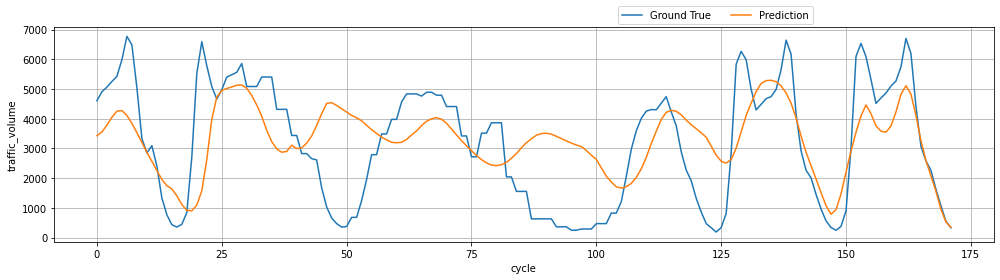

In [18]:
## Number of samples to display
nSamples = 172

## De-codifing results
y_true = y_test.ravel()*scale.scale_[-1] + scale.mean_[-1]
predict_dec = prediction.ravel()*scale.scale_[-1] + scale.mean_[-1]

## Display graphic
plt.figure(figsize=(14, 4))
if nSamples == 'all':
    plt.plot(y_true, label='Ground True')
    plt.plot(predict_dec, label='Prediction')
else:
    plt.plot(y_true[:nSamples], label='Ground True')
    plt.plot(predict_dec[:nSamples], label='Prediction')
plt.legend(loc=[0.6, 1.01], ncol=2)
plt.ylabel('traffic_volume'); plt.xlabel('cycle')
plt.grid()
plt.tight_layout()
plt.show()